In [39]:
!pip install einops

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image 

from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

(866, 1280)


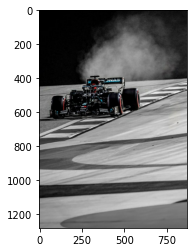

In [41]:
img = Image.open('/content/WhatsApp Image 2020-12-10 at 19.40.24 (2).jpeg')
plt.imshow(img)
print(img.size)

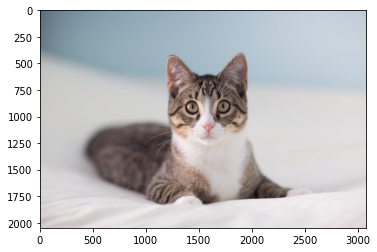

In [42]:
img = Image.open('/content/cat.jpg')
plt.imshow(img)

In [43]:
transforms = Compose([Resize((224, 224)), ToTensor()])
x = transforms(img).unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

In [44]:
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [45]:
print(x.shape)
print(patches.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [46]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16, emb_size : int = 768):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1 = self.patch_size, s2 = self.patch_size),
        nn.Linear(self.patch_size * self.patch_size * in_channels, emb_size)
    )


  def forward(self, x):
    x = self.projection(x)
    return x

PatchEmbedding()(x).shape      

torch.Size([1, 196, 768])

In [47]:
#Make it faster using convolutions instead of FC layer

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16, emb_size : int = 768):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        #Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1 = self.patch_size, s2 = self.patch_size),
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )


  def forward(self, x):
    x = self.projection(x)
    return x

PatchEmbedding()(x).shape      

torch.Size([1, 196, 768])

In [48]:
cls = torch.randn(1,1,768)
cls_tokens = repeat(cls, '() n e -> b n e', b=2)
cls_tokens.shape

torch.Size([2, 1, 768])

In [49]:
### adding a CLS Token to the PatchEmbedding class

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16, emb_size : int = 768):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        #Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1 = self.patch_size, s2 = self.patch_size),
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )

    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))


  def forward(self, x):
    b = x.shape[0]
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
    x = torch.cat([cls_tokens, x] , dim = 1)
    return x

PatchEmbedding()(x).shape      

torch.Size([1, 197, 768])

In [50]:
## ViT is made to learn the pos embeddings, shape is [n_patches + 1, emb_size]

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, patch_size : int = 16, emb_size : int = 768, in_size : int = 224):
    super().__init__()
    self.patch_size = patch_size
    self.projection = nn.Sequential(
        #Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1 = self.patch_size, s2 = self.patch_size),
        nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )

    self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
    self.positions = nn.Parameter(torch.randn((in_size // patch_size) ** 2 + 1, emb_size))


  def forward(self, x):
    b = x.shape[0]
    x = self.projection(x)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
    x = torch.cat([cls_tokens, x] , dim = 1)
    x += self.positions 
    
    return x

PatchEmbedding()(x).shape      

torch.Size([1, 197, 768])

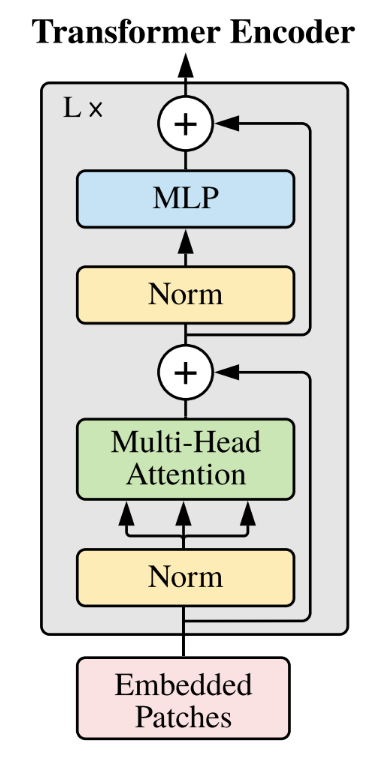

First we design the residual addition part

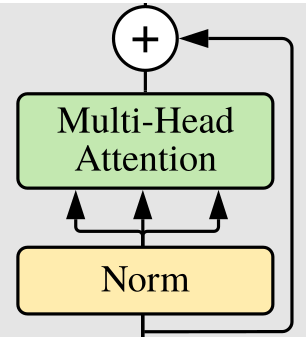

In [51]:
# In ViT only the Encoder is used

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res

    return x  

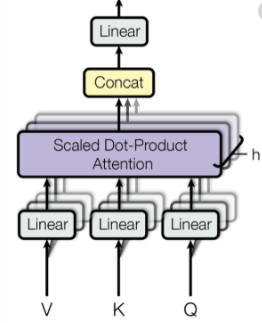

In [52]:
### need to define Multi headed attention

#MHA using 4 different linear layers

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size : int = 512, num_heads : int = 8, dropout : float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.queries = nn.Linear(emb_size, emb_size)
    self.keys = nn.Linear(emb_size, emb_size)    
    self.values = nn.Linear(emb_size, emb_size)   
    self.drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x, mask = None):
    queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h = self.num_heads)
    keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h = self.num_heads)  
    values = rearrange(self.values(x), "b n (h d) -> b h n d", h = self.num_heads) 

    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    scaling = self.emb_size ** (1/2)
    att = F.softmax(energy, dim = 1)/scaling 
    #final mult

    out = torch.einsum('bhal, bhlv -> bhav', att, values) 
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

In [56]:
## Using multiheaded attention in a single matrix of qkv

class MultiHeadAttention(nn.Module):
  def __init__(self, emb_size : int = 768, num_heads : int = 8, dropout : float = 0):
    super().__init__()
    self.emb_size = emb_size
    self.num_heads = num_heads
    self.qkv = nn.Linear(emb_size, 3 * emb_size)  
    self.drop = nn.Dropout(dropout)
    self.projection = nn.Linear(emb_size, emb_size)

  def forward(self, x, mask = None):
    qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h = self.num_heads, qkv = 3)

    queries, keys, values = qkv[0], qkv[1], qkv[2]
    energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    scaling = self.emb_size ** (1/2)
    att = F.softmax(energy, dim = 1)/scaling 
    #final mult

    out = torch.einsum('bhal, bhlv -> bhav', att, values) 
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)
    return out

patches_embeddings = PatchEmbedding()(x)
MultiHeadAttention()(patches_embeddings).shape    

torch.Size([1, 197, 768])

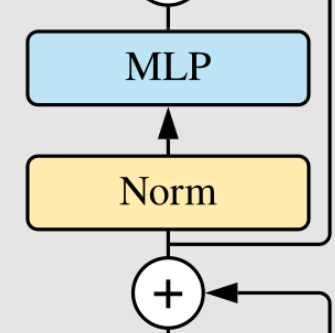

In [57]:
# MLP architecture used here ----

class MLPBlock(nn.Sequential):
  def __init__(self, emb_size, expansion = 4, drop_p = 0.):
    super().__init__(
        nn.Linear(emb_size, expansion * emb_size),
        nn.GELU(),
        nn.Dropout(drop_p),
        nn.Linear(expansion * emb_size, emb_size)
    )

In [60]:
# full block for transformer encoder ----

class TransformerEncoderBlock(nn.Sequential):
  def __init__(self, 
               emb_size = 768,
               drop = 0.,
               expansion = 4,
               forward_drop = 0.,
               **kwargs):
    super().__init__(
        ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop)
        )),

        ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MLPBlock(emb_size, expansion, forward_drop),
            nn.Dropout(forward_drop)
        ))
    )

In [61]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [62]:
## L blocks of the unit is needed

class TransformerEncoder(nn.Sequential):
  def __init__(self, L = 12, **kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(L)])

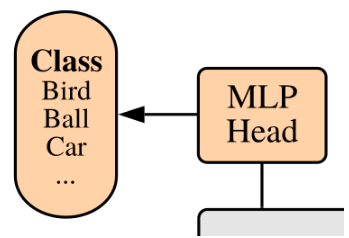

In [63]:
## Classification Head

class ClassificationMLP(nn.Sequential):
  def __init__(self, emb_size = 768, n_classes = 1000):
    super().__init__(
        Reduce('b n e -> b e', reduction = 'mean'),
        nn.LayerNorm(emb_size),
        nn.Linear(emb_size, n_classes)
    )

In [64]:
#Vision Transformer --- FINAL MODEL

class ViT_Torch(nn.Sequential):
  def __init__(self, 
               channels = 3,
               patch_size = 16,
               emb_size = 768,
               input_size = 224,
               L = 12,
               n_classes = 1000,
               **kwargs):
    super().__init__(
        PatchEmbedding(channels, patch_size, emb_size, input_size),
        TransformerEncoder(L, **kwargs),
        ClassificationMLP(emb_size, n_classes)
    )

In [65]:
summary(ViT_Torch(), (3, 224, 224), device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
            Linear-6             [-1, 197, 768]         590,592
MultiHeadAttention-7             [-1, 197, 768]               0
           Dropout-8             [-1, 197, 768]               0
       ResidualAdd-9             [-1, 197, 768]               0
        LayerNorm-10             [-1, 197, 768]           1,536
           Linear-11            [-1, 197, 3072]       2,362,368
             GELU-12            [-1, 197, 3072]               0
          Dropout-13            [-1, 197, 3072]               0
           Linear-14             [-1, 1